# LIM forecasting: sic + tas

Katie Brennan  
started March 31, 2020  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
#sys.path.append("/Users/hakim/gitwork/LMR_python3")
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")
import LMR_utils

In [2]:
# Define of the name of the variable to use for the LIM
#var_to_extract = 'tas'
# tos is not working due to mask issues...
var_to_extract = ['tas','zg500','psl','pr']

# for the LIM readme
data_source = 'CCSM4 last millennium simulation'

In [11]:
# number of EOFs to retain for the LIM state vector
ntrunc = 400 # EOF truncation for individual fields (reduced-state space)
nmodes = 60 # number of coupled EOFs for LIM state space (truncated-state space)

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
# fraction of years used in training
# ensures that start year of both train and validation data is january 
ntrain = 0.4

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','zg']
#limvars = ['tas','rlut','zg']
#limvars = ['sic']
limvars = ['tas','sic']
#limvars = ['tas','sic','zg500','psl','pr'
nvars = len(limvars)

# specify the model source 
dsource = 'ccsm4_lm'

# select 2 variables for analysis and plotting
var_dict = {}

# for n,var in enumerate(limvars):
#     var_dict['var'+str(n+1)]={'varind','var_inds'}

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
from collections import OrderedDict 

In [5]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [6]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as lim

In [46]:
import importlib
importlib.reload(lim)

<module 'LIM_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py'>

In [8]:
import time as timestamp # avoids conflict with local naming!

In [12]:
pi = np.pi

# fill continents if plotting SST; otherwise no
if var_to_extract == 'tos':
    noland = True
else:
    noland = False

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

fdic = lim.build_training_dic(dsource)

In [13]:
#----------- end of function definitions --------------

In [17]:
#
# load CCSM4 past1000 data...
#
for k, var in enumerate(limvars): 
    print('Loading '+var)
    data_in,lat_2d,lon_2d, time_yrs = lim.get_data(var,fdic[var], 45, 72)
    ntime = data_in.shape[0]
    nlat = data_in.shape[1]
    nlon = data_in.shape[2]
    X_var = np.moveaxis(np.reshape(data_in,[ntime,nlat*nlon]),0,-1) 
    if k == 0: 
        X_all = np.zeros((nvars,nlat*nlon,ntime))
    X_all[k,:,:] = X_var

Loading tas
fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 2.4706742763519287 seconds
-----------------------------------------------------
(12012, 192, 288)
indlat= 0  indlon= 1
('lat', 'lon')
regridding data...
nlat: 192
nlon: 288
(55296, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 2.139692783355713 seconds
-----------------------------------------------------
Removing climo from:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11
Loading sic
fetching  sic  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 1.8734979629516602 seconds
--------------------------------

In [30]:
# combine fields in the row space into a full state vector
if nvars > 1:
    for k in range(nvars-1):
        if k == 0:
            X = np.concatenate((X_all[0],X_all[1]),axis=0)
        else:
            X = np.concatenate((X,X_all[k+1]),axis=0)
else:
    X = np.squeeze(np.copy(X_all))
    
print(X.shape)

(6480, 12012)


In [18]:
# set location indices for each variable
ndof = X_all[0,:].shape[0]

# dictionary with the field info
fields = OrderedDict()
for k in range(nvars):
    d = {}
    var_inds = np.arange(k*ndof,(k+1)*ndof)
    fields[limvars[k]] = var_inds
    d['varind'] = k
    d['var_inds'] = var_inds
    var_dict['var'+str(k+1)] = d
        
print(fields.keys())
print(var_dict)

odict_keys(['tas', 'sic'])
{'var1': {'varind': 0, 'var_inds': array([   0,    1,    2, ..., 3237, 3238, 3239])}, 'var2': {'varind': 1, 'var_inds': array([3240, 3241, 3242, ..., 6477, 6478, 6479])}}


In [19]:
# PH approach: coupled-EOFs in truncated EOF space. 

# weight matrix for equal-area covariance normalization
tmp = np.sqrt(np.cos(np.radians(lat_2d)))
W = np.reshape(tmp,[nlat*nlon,1])
# note W*X = X*W

E3 = np.zeros([ndof*nvars,ntrunc*nvars])
for k in range(nvars):
    print('decomposing...',limvars[k])
    u,s,v = np.linalg.svd(W*np.nan_to_num(X_all[k,:,:]),full_matrices=False)
    fvar = 100*s*s/np.sum(s*s)
    print('fraction in first '+str(ntrunc)+ ' '+limvars[k]+' EOFs = ',np.sum(fvar[:ntrunc]))

    # projection
    P_var = np.matmul(u[:,:ntrunc].T,np.nan_to_num(X_all[k,:,:]))

    if k == 0:
        Ptrunc = P_var
    else:
        Ptrunc = np.concatenate((Ptrunc,P_var),axis=0)
      
    # reverse operator from EOFs to grid point space
    E3[k*ndof:(k+1)*ndof,k*ntrunc:(k+1)*ntrunc] = u[:,:ntrunc]
    
# truncate the coupled covariance matrix
u,s,v = np.linalg.svd(Ptrunc,full_matrices=False)
Etrunc = u[:,0:nmodes]
P = np.matmul(Etrunc.T,Ptrunc)
# reverse operator from *truncated* EOF space to full grid point space
E = np.matmul(E3,Etrunc)
print(E.shape)

decomposing... tas
fraction in first 400 tas EOFs =  94.31516300089059
decomposing... sic
fraction in first 400 sic EOFs =  98.08827701248438
(6480, 60)


In [22]:
# prepare the data to train and test the LIM. 
# separate data into training the validation sets 
tsamp = P.shape[1]
nyears = tsamp/12
ntrain_yrs = int(np.floor((tsamp/12)*ntrain)*12)
train_inds = np.arange(0,ntrain_yrs)
valid_inds = np.arange(ntrain_yrs,tsamp,1)

x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
yrs_train = time_yrs[train_inds]
yrs_valid = time_yrs[valid_inds]

print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (60, 4800)
validation data shape:  (60, 7212)


In [31]:
# climo standardized variance for error normalization 
#  in training and validation (1=no skill)
# EOF space only
E_x_train = np.matmul(E,x_train)
E_x_valid = np.matmul(E,x_valid)

nyrs_train = int(E_x_train.shape[1]/12)
nyrs_valid = int(E_x_valid.shape[1]/12)
nlalo = E_x_train.shape[0]

train_var_mon = np.var(np.reshape(E_x_train,(nlalo,nyrs_train,12)),
                       axis=1,ddof=1)
valid_var_mon = np.var(np.reshape(E_x_valid,(nlalo,nyrs_valid,12)),
                       axis=1,ddof=1)
train_var = np.var(E_x_train,axis=1,ddof=1)
valid_var = np.var(E_x_valid,axis=1,ddof=1)

# FULL FIELD versions of the variance 
train_var_full = np.var(X[:,train_inds],axis=1,ddof=1)
valid_var_full = np.var(X[:,valid_inds],axis=1,ddof=1)

valid_var_mon_full = np.var(np.reshape(X[:,valid_inds],(nlalo,nyrs_valid,12)),
                            axis=1,ddof=1)

In [32]:
valid_variance_eof = lim.calc_gm_polar_variance(valid_var,valid_var_mon,
                                                fields,lat_2d[:,0],lon_2d[0,:])
valid_variance_full = lim.calc_gm_polar_variance(valid_var_full,valid_var_mon_full,
                                                 fields,lat_2d[:,0],lon_2d[0,:])

valid_variance_eof['tas_lalo'] = np.reshape(valid_var[fields['tas']],[nlat,nlon])
valid_variance_full['tas_lalo'] = np.reshape(valid_var_full[fields['tas']],[nlat,nlon])
valid_variance_eof['sic_lalo'] = np.reshape(valid_var[fields['sic']],[nlat,nlon])
valid_variance_full['sic_lalo'] = np.reshape(valid_var_full[fields['sic']],[nlat,nlon])

valid_variance_eof['sic_mon_lalo'] = np.reshape(valid_var_mon[fields['sic']],[nlat,nlon,12])
valid_variance_full['sic_mon_lalo'] = np.reshape(valid_var_mon_full[fields['sic']],[nlat,nlon,12])

tas
sic
tas
sic


In [33]:
# climo mean and covariance in EOF space sampled over all times
Pm = np.mean(P,axis=1,keepdims=True)
tmp = P - Pm
Cc = np.matmul(tmp,tmp.T)/(tmp.shape[1]-1)

In [34]:
# train the LIM
LIMd, G = lim.LIM_train(tau,x_train)
print('Training LIM with tau = '+str(tau))

Training LIM with tau = 1


In [42]:
nmodes

60

In [50]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(13)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
#truth = np.real(np.matmul(E,x_train))
#truth = X[:,train_inds]
#LIMfd_train = LIM_utils.LIM_forecast(LIMd,x_train,lags,E,truth)

# validation data
#truth = np.real(np.matmul(E,x_valid))
truth = X[:,valid_inds]
LIMfd_valid = lim.LIM_forecast_test(G,x_valid,lags,E,truth,yrs_valid, nvars, nlat*nlon, nmodes=60)

t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


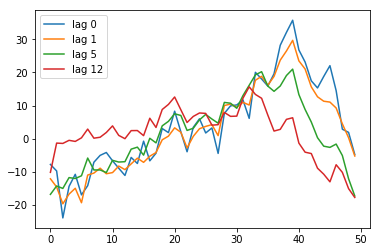

In [62]:
plt.plot(np.arange(0,50,1),LIMfd_valid['x_forecast'][0,0,:50], label='lag 0')
plt.plot(np.arange(0,50,1),LIMfd_valid['x_forecast'][1,0,1:51], label='lag 1')
plt.plot(np.arange(0,50,1),LIMfd_valid['x_forecast'][5,0,5:55], label='lag 5')
plt.plot(np.arange(0,50,1),LIMfd_valid['x_forecast'][12,0,12:62], label='lag 12')
plt.legend()

In [426]:
[error_all_mon, 
 error_mon, rmse,
time_ermon] = lim.calc_forecast_error_by_mon(LIMfd_valid['x_forecast'],1, 
                                             truth,E,LIMfd_valid['time_forecast'])
[error_all_mon_eof, 
 error_mon_eof, rmse_eof, 
 time_ermon2] = lim.calc_forecast_error_by_mon(LIMfd_valid['x_forecast'],1, 
                                               truth, E,LIMfd_valid['time_forecast'])
rmse2 = np.mean(error_all_mon**2,axis=2)

evar_mon_gm = np.zeros([12])
rmse_mon_gm = np.zeros([12])

tas_error_mon = np.moveaxis(np.reshape(error_mon[fields['tas'],:],[nlat,nlon,12]),-1,0)
tas_rmse = np.moveaxis(np.reshape(rmse[fields['tas'],:],[nlat,nlon,12]),-1,0)
evar_mon_gm,_,_ = LMR_utils.global_hemispheric_means(tas_error_mon,lat_2d[:,0])
rmse_mon_gm,_,_ = LMR_utils.global_hemispheric_means(tas_rmse,lat_2d[:,0])

sic_rmse = np.reshape(rmse[fields['sic'],:].T, [12,nlat,nlon])
sic_error_mon = np.reshape(error_mon[fields['sic'],:].T, [12,nlat,nlon])
rmse_mon_polar = lim.polar_regional_means(sic_rmse,lat_2d[:,0],lon_2d[0,:])
evar_mon_polar = lim.polar_regional_means(sic_error_mon,lat_2d[:,0],lon_2d[0,:])

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:384: RuntimeWarning: Degrees of freedom <= 0 for slice.
  error_mon = np.nanvar(error_rs, axis=1,ddof=1)
/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:385: RuntimeWarning: Mean of empty slice
  rmse = np.nanmean(error_rs**2,axis=1)


In [427]:
rmse_mon_polar.shape, sic_error_mon.shape

((2, 12), (12, 45, 72))

In [428]:
# compute errors in both the EOF space and full grid point space
err,err_gm = lim.LIM_forecast_error(LIMfd_valid,truth,
                                    E,lags,fields,lat_2d)
err_eofs,err_gm_eofs = lim.LIM_forecast_error(LIMfd_valid,np.real(np.matmul(E,x_valid)),
                                              E,lags,fields,lat_2d)

lag =  0
lag =  1
lag =  2
lag =  3
lag =  4
lag =  5
lag =  6
lag =  7
lag =  8
lag =  9
lag =  10
lag =  11
lag =  12
lag =  0
lag =  1
lag =  2
lag =  3
lag =  4
lag =  5
lag =  6
lag =  7
lag =  8
lag =  9
lag =  10
lag =  11
lag =  12


In [429]:
valid_variance_eof.keys()

dict_keys(['tas_gm', 'tas_gm_mon', 'tas_polarm', 'tas_polarm_mon', 'sic_gm', 'sic_gm_mon', 'sic_polarm', 'sic_polarm_mon', 'tas_lalo', 'sic_lalo', 'sic_mon_lalo'])

In [430]:
valid_gm_var['var1'], valid_variance_eof['tas_gm'], var_dict['var1']['varind']

(array([0.74583861]), array([0.74583861]), 0)

Text(0.5,1,'LIM normalized global error variance')

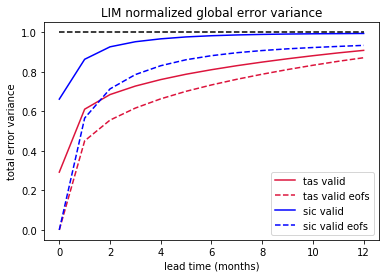

In [431]:
color_list = ['crimson','b']

for n,var in enumerate(fields.keys()): 
    plt.plot(lags,err_gm[n,:]/valid_variance_full[var+'_gm'],
             color=color_list[n],linestyle='-',label=list(fields.keys())[n]+' valid')
    plt.plot(lags,err_gm_eofs[n,:]/valid_variance_eof[var+'_gm'],
             color=color_list[n],linestyle='--',label=list(fields.keys())[n]+' valid eofs')

plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
#plt.ylim(0,1)
plt.legend()
plt.title('LIM normalized global error variance')

In [432]:
valid_variance_full.keys()

dict_keys(['tas_gm', 'tas_gm_mon', 'tas_polarm', 'tas_polarm_mon', 'sic_gm', 'sic_gm_mon', 'sic_polarm', 'sic_polarm_mon', 'tas_lalo', 'sic_lalo', 'sic_mon_lalo'])

Text(0.5,1,'LIM normalized error variance')

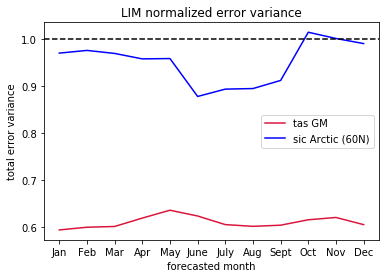

In [433]:
color_list = ['crimson','b']
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

plt.plot(range(12),evar_mon_gm/valid_variance_full['tas_gm'],
         color='crimson',linestyle='-',label='tas GM')
plt.plot(range(12),evar_mon_polar[0,:]/valid_variance_full['sic_polarm_mon'][0,:],
         color='b',label='sic Arctic (60N)')
    
plt.axhline(1,0,12,color='k',linestyle='--')    
plt.xticks(range(12),mlabels)
plt.xlabel('forecasted month')
plt.ylabel('total error variance')
#plt.ylim(0,1)
plt.legend()
plt.title('LIM normalized error variance')

Text(0.5,1,'LIM performance by month')

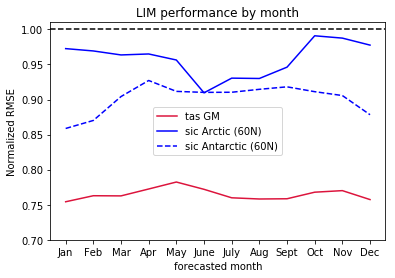

In [444]:
color_list = ['crimson','b']
mlabels = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

plt.plot(range(12),rmse_mon_gm/np.sqrt(valid_gm_var['var1_mon_full']),
         color='crimson',linestyle='-',label='tas GM')
plt.plot(range(12),rmse_mon_polar[0,:]/np.sqrt(valid_variance_full['sic_polarm_mon'][0,:]),
         color='b',label='sic Arctic (60N)')
plt.plot(range(12),rmse_mon_polar[1,:]/np.sqrt(valid_variance_full['sic_polarm_mon'][1,:]),
         color='b',linestyle='--',label='sic Antarctic (60N)')
    
plt.axhline(1,0,12,color='k',linestyle='--')    
plt.xticks(range(12),mlabels)
plt.xlabel('forecasted month')
plt.ylabel('Normalized RMSE')
plt.ylim(0.7,1.01)
plt.legend()
plt.title('LIM performance by month')

In [435]:
valid_variance_full['sic_mon_lalo'].shape

(45, 72, 12)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


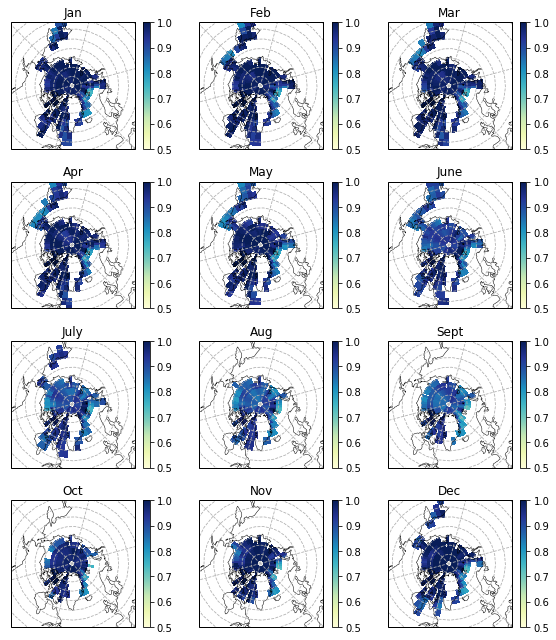

In [445]:
fig,ax = plt.subplots(4,3, figsize=(8,9), subplot_kw = arc_proj)
ax = ax.flatten()

for m in range(12):
    lim.sub_arctic_plot(ax[m],fig,sic_rmse[m,:,:]/np.sqrt(valid_variance_full['sic_mon_lalo'][:,:,m]),
                        lat_2d,lon_2d, minv=0.5, maxv=1,cmap='YlGnBu')
    ax[m].set_title(mlabels[m])

plt.tight_layout()

# plt.savefig((save_dir+var_to_extract+'/'+var_to_extract+
#              '_error_arctic_spatial_plots_randtime_eof'+str(nmodes)+'_tau'+
#              str(tau)+'_'+today_date+'.png'),dpi=300)

In [241]:
sic_rmse.shape

(12, 45, 72)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


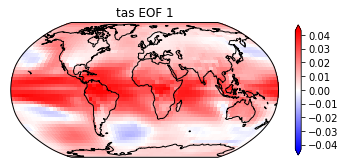

Text(0.5,1,'sic EOF 1')

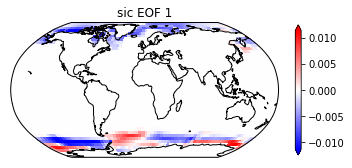

In [233]:
# plot the coupled EOFs
mode = 0
lim.plot_map_vector(E[var_dict['var1']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[0]+' EOF '+str(mode+1))
plt.show()
lim.plot_map_vector(E[var_dict['var2']['var_inds'],mode],lat_2d,lon_2d)
plt.title(list(fields.keys())[1]+' EOF '+str(mode+1))

In [ ]:
LIMd['vec'].shape

In [ ]:
fields

In [ ]:
var1_inds

In [ ]:
# reshape (nx,ntime)
X = np.moveaxis(np.reshape(data_in_sic,[ntime,nlat*nlon]),0,-1) 
print('Original shape: '+str(data_in_sic.shape))
print('Shape of X: '+str(X.shape))

In [ ]:
X_nonan = np.where(np.isnan(X.data),0,X.data)
X_nonan_arctic = X_nonan
X_nonan_arctic[np.where(lat_2d.reshape(nlat*nlon)<0),:] = 0

In [ ]:
plot_map_vector(X_nonan_arctic[:,800].data,lat_2d,lon_2d)

In [ ]:
X_nonan_arctic_mon = np.reshape(X_nonan_arctic,(3240,1001,12))
X_arctic_FMA = X_nonan_arctic_mon[:,:,1:4].reshape(3240,3003) 
X_arctic_ASO = X_nonan_arctic_mon[:,:,7:10].reshape(3240,3003) 

X_arctic_FMA_anom = X_arctic_FMA - np.nanmean(X_arctic_FMA,axis=1)[:,np.newaxis]
X_arctic_ASO_anom = X_arctic_FMA - np.nanmean(X_arctic_ASO,axis=1)[:,np.newaxis]

In [ ]:
var.shape, W.shape, X_check.shape

In [ ]:
var = X_nonan_arctic_mon[:,:,2] - np.nanmean(X_nonan_arctic_mon[:,:,2],axis=1)[:,np.newaxis]
u,s,v,W = calc_eof(var, lat_2d)

# check SVD
print('checking svd (success for True response)...')
X_check = np.matmul(np.matmul(u,np.diag(s)),v)
print(np.allclose(X_check,W*var))

In [ ]:
plot_eigenvalues(s,var_to_extract)

In [ ]:
plot_map_vector(-u[:,0],lat_2d,lon_2d)

In [ ]:
# project data onto a subset of the EOF basis

# EOF basis
if var_to_extract == 'tos':
    E = u[:,1:nmodes+1]
else:
    E = u[:,0:nmodes]

# project---this doesn't work for tos? masked array/nan issue I don't understand
#P = np.matmul(E.T,X)

# alternative from SVD results. recall v is v.T in numpy. 
# NOTE: this is the projection with W weighting, which is not the same as projecting unweighted data

# 7/13/2020: projection of unweighted data; tos doesn't work with this approach
if var_to_extract == 'tos':
    #P_w = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
    P = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
else:
    #P_w = np.matmul(np.diag(s[0:nmodes]),v[0:nmodes,:])
    P = np.matmul(E.T,var)

In [ ]:
# reconstruct from the limited projection, and compare with the original (error)
check = np.matmul(E,P)
print(np.max(check))
print(check.shape)

# pick a random time to plot
itim = 21

plot_map_vector(var[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Original')
plt.show()
plot_map_vector(check[:,itim],lat_2d,lon_2d,maxv=3)
plt.title('Limited EOF projection')
plt.show()

In [ ]:
# make sure P has zero mean first !!!
Pzero = np.max(np.abs(np.mean(P,axis=1)))
if Pzero > 1e-6:
    print('warning!!! the projected state does not have zero-mean in the time domain '
         )

In [ ]:
ntrain = 500

In [ ]:
# prepare the data to train and test the LIM. separate data into training the validation sets 
tsamp = P.shape[1]

train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

In [ ]:
# climo standardized variance for error normalization in training and validation (1=no skill)
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)

In [ ]:
nt = x_train.shape[1]
C_1 = np.matmul(x_train[:,tau:],x_train[:,:-tau].T)/(nt-1)
tau

In [ ]:
C1_phys_space = np.matmul(C_1,E.T)

plot_map_vector(C1_phys_space[0,:],lat_2d,lon_2d,maxv=3)
plt.title('lagged_covariance')
plt.show()

In [ ]:
tau = 1

In [ ]:
# train the LIM
LIMd = LIM_train(tau,x_train)

In [ ]:
lags

In [ ]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(4)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
LIMfd_train = LIM_forecast(LIMd,x_train,lags,E)

# validation data
LIMfd_valid = LIM_forecast(LIMd,x_valid,lags,E)

In [ ]:
LIMfd_train.keys()

In [ ]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_error_3d = np.reshape(LIMfd_train['error'],[nlat,nlon,ntims])
LIMfd_valid_error_3d = np.reshape(LIMfd_valid['error'],[nlat,nlon,ntims])

[train_gm_err,
 train_nh_err,
 train_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_train_error_3d,-1,0),lat_2d[:,0])
[train_gm_var,
 train_nh_var,
 train_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(train_var[:,None],[nlat,nlon]),lat_2d[:,0])
[valid_gm_err,
 valid_nh_err,
 valid_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_valid_error_3d,-1,0),lat_2d[:,0])
[valid_gm_var,
 valid_nh_var,
 valid_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None],[nlat,nlon]),lat_2d[:,0])


In [ ]:
# plot global-mean normalized error variance
plt.plot(lags,train_nh_err/train_nh_var,'b-',label='train')
plt.plot(lags,valid_nh_err/valid_nh_var,'r-',label='valid')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_error_growth_1_6_12months',dpi=300)

In [ ]:
# plot maps of select forecasts and errors for a chosen lag in months (and time, itime)
ilag = 1
plot_map_vector(LIMfd_train['error'][:,ilag]/train_var,lat_2d,lon_2d,cmap='PuOr_r')
plt.title('Error')
plt.show()
itime = 1
plot_map_vector(np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d,minv=-4,maxv=4 )
plt.title('Forecast state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime],lat_2d,lon_2d,minv=-4,maxv=4)
plt.title('True state')
plt.show()
plot_map_vector(X_nonan_arctic[:,itime] -np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),lat_2d,lon_2d)
plt.title('True - Forecast state')
plt.show()

In [ ]:
forecast_state_train = np.matmul(E,LIMfd_train['x_forecast']) 
true_state_train = X_arctic_FMA[:,train_inds]
true_state_train.shape, forecast_state_train.shape

In [ ]:
initialt = 1
plt.plot(np.arange(0,13,1),true_state_train[3200,initialt:initialt+13], label='truth')
plt.plot(np.arange(0,13,1),forecast_state_train[:,3200,initialt], label='forecast')
plt.legend()

r = np.zeros(4000-12)

for it in range(4000-12):
    r[it] = np.corrcoef(true_state_train[3000,it:it+13],forecast_state_train[:,3000,it])[0,1]

In [ ]:
plt.plot(r)
#plt.xlim(3900,4000)
r.mean()

In [ ]:
LIMfd_train.keys(), x_valid.shape, E.shape, lags

In [ ]:
LIMfd_train['x_truth_phys_space'].shape,LIMfd_train['x_forecast_phys_space'].shape, LIMfd_train['error'].shape, LIMfd_train['x_forecast'].shape

In [ ]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_truth_3d = np.reshape(LIMfd_train['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_train_forecast_3d = np.reshape(LIMfd_train['x_forecast_phys_space'],[nlat,nlon,3988])
LIMfd_valid_truth_3d = np.reshape(LIMfd_valid['x_truth_phys_space'],[nlat,nlon,3988])
LIMfd_valid_forecast_3d = np.reshape(LIMfd_valid['x_forecast_phys_space'],[nlat,nlon,3988])

[train_truth_gm,
 train_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_truth_3d,lat_2d[:,0])
[train_forecast_gm,
 train_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_train_forecast_3d,lat_2d[:,0])
[valid_truth_gm,
 valid_truth_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_truth_3d,lat_2d[:,0])
[valid_forecast_gm,
 valid_forecast_nh,_] = LMR_utils.global_hemispheric_means(LIMfd_valid_forecast_3d,lat_2d[:,0])



## Independent validation: 

In [ ]:
# load 20cr data for independent validation...
data_20cr,_,_ = get_data(var_to_extract,infile_20cr_tas, 45, 72)
ntime_20cr = data_20cr.shape[0]

In [ ]:
# back to (nx,ntime)
X_20cr = np.moveaxis(np.reshape(data_20cr,[ntime_20cr,nlat*nlon]),0,-1) 

# test the LIM on 20CR monthly data projected on the same basis
P_20cr = np.matmul(E.T,X_20cr)

# climo standardized variance
valid_var_20cr = np.var(np.matmul(E,P_20cr),axis=1,ddof=1)

In [ ]:
# CCSM LIM forecasts on 20cr states
LIMfd_20cr = LIM_forecast(LIMd,P_20cr,lags,E)

In [ ]:
# proper area-weighted global-mean values
valid_gm_err_20cr,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_20cr['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var_20cr,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_20cr[:,None],[nlat,nlon]),lat_2d[:,0])


In [ ]:
plt.plot(lags,valid_gm_err/valid_gm_var,'k-',label='ccsm')
plt.plot(lags,valid_gm_err_20cr/valid_gm_var_20cr,'r-',label='20cr')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_forecast_error_ccsm_20cr_6mo',dpi=300)